In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import math

class ConditionalDiffusionModel(nn.Module):
    def __init__(self, input_size, weight_template_size):
        super(ConditionalDiffusionModel, self).__init__()
        self.fc1 = nn.Linear(input_size + weight_template_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, input_size)

    def forward(self, x, condition):
        # Concatenate the image and weight template (condition)
        x = torch.cat((x, condition), dim=-1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [2]:
class DiffusionTrainer:
    def __init__(self, model, timesteps=1000):
        self.model = model
        self.timesteps = timesteps
        self.beta = np.linspace(1e-4, 0.02, timesteps)  # Linear schedule
        self.alpha = 1 - self.beta
        self.alpha_bar = np.cumprod(self.alpha)

    def sample_noise(self, shape):
        return torch.randn(shape)

    def q_sample(self, x_start, t):
        noise = self.sample_noise(x_start.shape).to(x_start.device)
        
        # Correct broadcasting for alpha_bar_t
        alpha_bar_t = torch.tensor(self.alpha_bar[t], dtype=torch.float32, device=x_start.device).view(-1, 1)
        
        return torch.sqrt(alpha_bar_t) * x_start + torch.sqrt(1 - alpha_bar_t) * noise

    def loss_fn(self, x_noisy, t, x_start, condition):
        predicted_x_start = self.model(x_noisy, condition)
        return F.mse_loss(predicted_x_start, x_start)
    # def loss_fn(self, x_noisy, t, x_start, condition):
    #     # Ensure x_noisy and condition are reshaped to [batch_size, channels, height, width]
    #     batch_size = x_noisy.size(0)
    #     num_pixels = x_noisy.size(1)
        
    #     # Calculate height and width from the number of pixels (adjust as per your dataset)
    #     height = int(math.sqrt(num_pixels))  # Assuming images are square
    #     width = height
        
    #     # Reshape the inputs
    #     x_noisy = x_noisy.view(batch_size, 1, height, width)  # Assuming 1 channel (grayscale)
    #     condition = condition.view(batch_size, 1, height, width)  # Reshape condition similarly
        
    #     # Pass the reshaped tensors into the model
    #     predicted_x_start = self.model(x_noisy, condition)
    #     return F.mse_loss(predicted_x_start, x_start.view(batch_size, 1, height, width))


    def train(self, data_loader, optimizer, weight_templates, num_epochs=100):
        for epoch in range(num_epochs):
            for i, (x_start, idx) in enumerate(data_loader):
                t = torch.randint(0, self.timesteps, (x_start.size(0),)).to(x_start.device)
                x_noisy = self.q_sample(x_start, t)
                condition = weight_templates[idx].to(x_start.device)

                loss = self.loss_fn(x_noisy, t, x_start, condition)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}")

# Input image size and weight template size
input_size = 150 * 150 * 1  # Example for 64x64 RGB images
weight_template_size = 150  # Assuming your weight template is 256-dimensional

# Initialize model
model = ConditionalDiffusionModel(input_size, weight_template_size)
optimizer = optim.Adam(model.parameters(), lr=0.001)
trainer = DiffusionTrainer(model)

# Example: Data loading (assume images and weight templates are in NumPy format)
# Here `images.npy` contains the training images and `weight_templates.npy` contains the corresponding weight templates.

import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Load images and weight templates
images = np.load("/Users/gvssriram/Desktop/projects-internship/PalmGenAI/Datasets/IITD Palmprint V1/Preprocessed/Left/X_train.npy")  # Shape: (N, 64, 64, 3)
weight_templates = np.load("/Users/gvssriram/Desktop/projects-internship/PalmGenAI/Datasets/IITD Palmprint V1/Preprocessed/Left/X_train_pca.npy")  # Shape: (N, 256)

# Preprocessing
images = torch.tensor(images).float().view(-1, input_size)  # Flatten images
weight_templates = torch.tensor(weight_templates).float()

# Create dataset and dataloader
dataset = TensorDataset(images, torch.arange(images.shape[0]))  # Pass indices for weight templates
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Train the model
trainer.train(data_loader, optimizer, weight_templates, num_epochs=50)


Epoch [1/50], Loss: 0.1601
Epoch [2/50], Loss: 0.1000
Epoch [3/50], Loss: 0.0619
Epoch [4/50], Loss: 0.0592
Epoch [5/50], Loss: 0.0422
Epoch [6/50], Loss: 0.0371
Epoch [7/50], Loss: 0.0374
Epoch [8/50], Loss: 0.0350
Epoch [9/50], Loss: 0.0422
Epoch [10/50], Loss: 0.0283
Epoch [11/50], Loss: 0.0286
Epoch [12/50], Loss: 0.0312
Epoch [13/50], Loss: 0.0284
Epoch [14/50], Loss: 0.0210
Epoch [15/50], Loss: 0.0255
Epoch [16/50], Loss: 0.0311
Epoch [17/50], Loss: 0.0326
Epoch [18/50], Loss: 0.0221
Epoch [19/50], Loss: 0.0299
Epoch [20/50], Loss: 0.0303
Epoch [21/50], Loss: 0.0210
Epoch [22/50], Loss: 0.0305
Epoch [23/50], Loss: 0.0432
Epoch [24/50], Loss: 0.0302
Epoch [25/50], Loss: 0.0235
Epoch [26/50], Loss: 0.0204
Epoch [27/50], Loss: 0.0263
Epoch [28/50], Loss: 0.0245
Epoch [29/50], Loss: 0.0235
Epoch [30/50], Loss: 0.0272
Epoch [31/50], Loss: 0.0240
Epoch [32/50], Loss: 0.0274
Epoch [33/50], Loss: 0.0285
Epoch [34/50], Loss: 0.0200
Epoch [35/50], Loss: 0.0196
Epoch [36/50], Loss: 0.0244
E

In [3]:
class DiffusionSampler:
    def __init__(self, model, timesteps=1000):
        self.model = model
        self.timesteps = timesteps
        self.beta = np.linspace(1e-4, 0.02, timesteps)  # Linear schedule
        self.alpha = 1 - self.beta
        self.alpha_bar = np.cumprod(self.alpha)

    def p_sample(self, x, t, condition):
        predicted_x_start = self.model(x, condition)
        alpha_bar_t = torch.tensor(self.alpha_bar[t], dtype=torch.float32, device=x.device)
        alpha_bar_t_prev = torch.tensor(self.alpha_bar[t-1], dtype=torch.float32, device=x.device) if t > 0 else torch.tensor(1.0, dtype=torch.float32, device=x.device)

        noise = torch.randn_like(x)
        return predicted_x_start * torch.sqrt(alpha_bar_t_prev) + noise * torch.sqrt(1 - alpha_bar_t_prev)

    def sample(self, condition, img_shape=(150, 150, 1)):
        x = torch.randn((1, np.prod(img_shape))).to(condition.device)
        for t in reversed(range(self.timesteps)):
            x = self.p_sample(x, t, condition)
        return x.view(img_shape)

# Initialize sampler
sampler = DiffusionSampler(model)

# Load weight templates for the user
user_weight_template = weight_templates[0]  # Shape: (256,)
user_weight_template = torch.tensor(user_weight_template).float().unsqueeze(0)

# Generate deepfake
generated_image = sampler.sample(user_weight_template)
generated_image = generated_image.detach().cpu().numpy()

# Reshape to original image dimensions and save or display
generated_image = generated_image.reshape(150, 150, 1)


/var/folders/9q/_q4q_3y536j3lx6cc49vl0840000gn/T/ipykernel_65800/82786077.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  user_weight_template = torch.tensor(user_weight_template).float().unsqueeze(0)


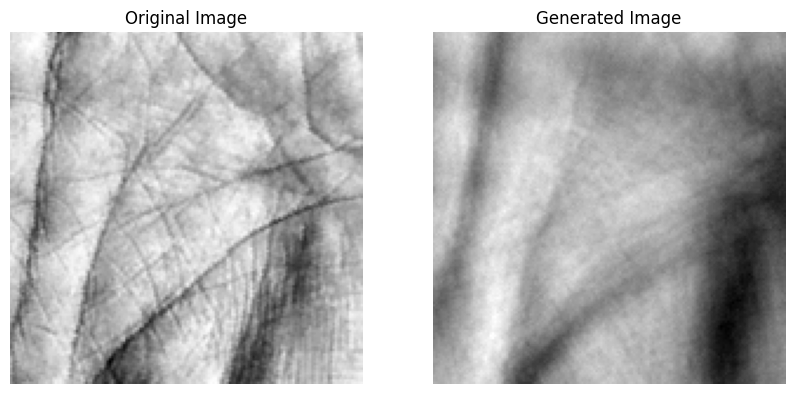

In [4]:
import matplotlib.pyplot as plt

# Displaying the original and generated images side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Original image
axes[0].imshow(images[0].reshape(150, 150), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Generated image
axes[1].imshow(generated_image.reshape(150, 150), cmap='gray')
axes[1].set_title("Generated Image")
axes[1].axis('off')

# Show the plot
plt.show()